In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/var/folders/st/kwps6pbj74j_zrv9wwqrs5z00000gn/T/ipykernel_1457/3867702945.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start=start_date, end=end_date, freq='M')


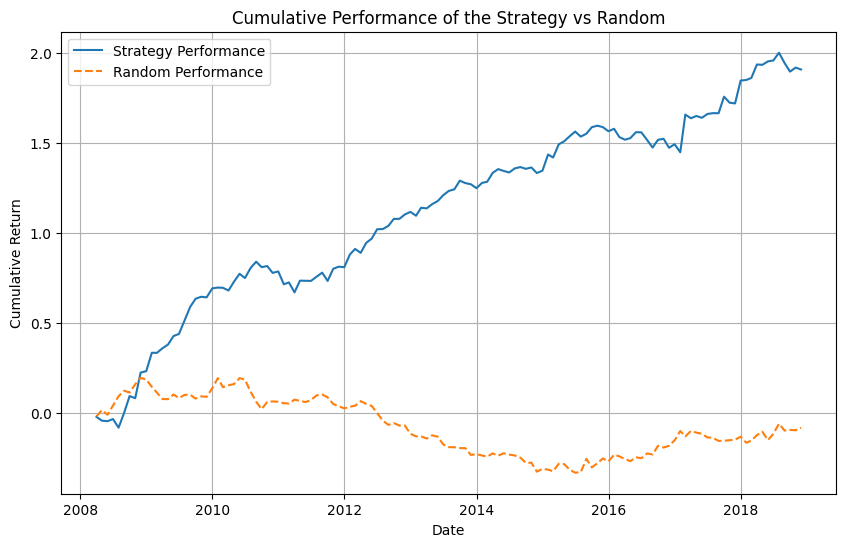

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Chargement des données et intersection des dates communes
file_path = 'DATA.xlsx'
returns = pd.read_excel(file_path, sheet_name='RETURNS', index_col=0, parse_dates=True)
price_to_book = pd.read_excel(file_path, sheet_name='PRICE TO BOOK', index_col=0, parse_dates=True)

common_dates = returns.index.intersection(price_to_book.index)
returns = returns.loc[common_dates]
price_to_book = price_to_book.loc[common_dates]

# Paramètres
start_date = '2008-03-31'
end_date = '2023-03-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='M')

# Calcul des scores momentum et valeur
# Ici, nous appliquons les fonctions pour calculer les scores momentum et valeur pour chaque action
# Le score momentum est basé sur les rendements moyens mensuels sur les 12 mois précédents (sans le dernier)
# Le score valeur est basé sur l'inverse du ratio cours/valeur comptable
def calculate_momentum_score(returns):
    return (returns.rolling(window=12, min_periods=12).mean().shift(1) - returns.mean()) / returns.std()

def calculate_value_score(price_to_book_ratios):
    return (1 / price_to_book_ratios.shift(1) - (1 / price_to_book_ratios).mean()) / (1 / price_to_book_ratios).std()

momentum_scores = returns.apply(calculate_momentum_score, axis=0)
value_scores = price_to_book.apply(calculate_value_score, axis=0)
global_scores = (momentum_scores + value_scores) / 2

# Rééquilibrage du portefeuille chaque mois
# Nous sélectionnons les 15 actions avec les scores globaux les plus élevés pour le portefeuille long
# et les 15 actions avec les scores les plus bas pour le portefeuille short. Les pondérations sont
# basées sur les scores globaux normalisés.
performance_list = []
weights_list = []

for date in date_range:
    if date not in global_scores.index:
        continue

    month_data = pd.DataFrame({
        'Returns': returns.loc[date],
        'Global_Score': global_scores.loc[date]
    }).dropna()

    top_15_long = month_data.nlargest(15, 'Global_Score')
    bottom_15_short = month_data.nsmallest(15, 'Global_Score')

    long_weights = abs(top_15_long['Global_Score']) / abs(top_15_long['Global_Score']).sum()
    short_weights = abs(bottom_15_short['Global_Score']) / abs(bottom_15_short['Global_Score']).sum()

    long_performance = (top_15_long['Returns'] * long_weights).sum()
    short_performance = (bottom_15_short['Returns'] * short_weights).sum()

    strategy_performance = long_performance - short_performance
    performance_list.append(strategy_performance)

    weights_list.append(pd.DataFrame({
        'Action': top_15_long.index.tolist() + bottom_15_short.index.tolist(),
        'Weight': long_weights.tolist() + (-short_weights).tolist(),
        'Date': date
    }))

# Exportation des performances et des pondérations dans un fichier Excel
performance_df = pd.DataFrame({'Date': date_range[:len(performance_list)], 'Performance': performance_list})
weights_df = pd.concat(weights_list)

with pd.ExcelWriter('strategy_performance.xlsx') as writer:
    performance_df.to_excel(writer, sheet_name='Performance', index=False)
    weights_df.to_excel(writer, sheet_name='Weights', index=False)

# Comparaison avec une stratégie long/short aléatoire
# Nous générons une stratégie "chance" en sélectionnant 30 actions au hasard pour chaque mois
# et nous calculons les performances comme pour la stratégie principale.
np.random.seed(42)
random_performances = []

for date in date_range:
    if date not in returns.index:
        continue

    random_actions = returns.loc[date].dropna().sample(30)
    random_long = random_actions.sample(15)
    random_short = random_actions.drop(random_long.index)

    random_long_weights = abs(global_scores.loc[date, random_long.index]) / abs(global_scores.loc[date, random_long.index]).sum()
    random_short_weights = abs(global_scores.loc[date, random_short.index]) / abs(global_scores.loc[date, random_short.index]).sum()

    random_long_performance = (random_long * random_long_weights).sum()
    random_short_performance = (random_short * random_short_weights).sum()

    random_performance = random_long_performance - random_short_performance
    random_performances.append(random_performance)

random_performance_df = pd.DataFrame({'Date': date_range[:len(random_performances)], 'Random_Performance': random_performances})

with pd.ExcelWriter('strategy_performance.xlsx', mode='a') as writer:
    random_performance_df.to_excel(writer, sheet_name='Random_Performance', index=False)

# Visualisation des performances cumulées de la stratégie vs. la stratégie aléatoire
plt.figure(figsize=(10, 6))
plt.plot(performance_df['Date'], performance_df['Performance'].cumsum(), label='Strategy Performance')
plt.plot(random_performance_df['Date'], random_performance_df['Random_Performance'].cumsum(), label='Random Performance', linestyle='--')
plt.title('Cumulative Performance of the Strategy vs Random')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()